# Disturbance Model Emulator

Designed to be run in Google colab

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import math, importlib

In [ ]:

# 1) Make sure you have build tools & headers (Colab usually does, but just in case)
!apt-get update -qq && apt-get install -qq -y build-essential python3-dev

In [ ]:
# 2) Install pybind11
!pip install -q pybind11

In [ ]:
%%writefile edgepulse.cpp
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <vector>
#include <cmath>

#ifdef _OPENMP
  #include <omp.h>
#endif

namespace py = pybind11;

/*
  Pattern:
  - run_*_impl: pure C++ (no pybind/Python) – safe in parallel
  - run_*_core: Python-visible scalar wrappers; release GIL here
  - run_*_batch_tstop: Python-visible batched; read arrays, allocate output,
    then release GIL ONCE and parallelize calling the *impl*.
*/

// -------------------- pure C++ implementations --------------------
static inline double run_one_impl(
    double t_max, double dt, double C,
    double tau_double, double trap_single, double k_double, double k_mult,
    double I_double, double I_single, double I_const,
    double k_switch,
    double t_on_A, double t_off_A, double t_on_P, double t_off_P
){
    if (dt <= 0.0 || C <= 0.0) return t_max;

    const double V_ON  = 0.1;
    const double V_TR  = 1.0;
    const double V_HI  = 1.2;

    const int n_steps = static_cast<int>(std::round(t_max / dt));
    const double period = (t_on_A + t_off_A + t_on_P + t_off_P);
    if (period <= 0.0) return t_max;

    double vA_prev = V_HI, vP_prev = 0.0;
    double t_edge  = -1e12, t_pedge = -1e12;
    // FIX: initialize to 0.5 * vA_prev * C
    double Q = 0.5 * vA_prev * C;

    double t_stop = t_max;

    for (int i = 0; i < n_steps; ++i) {
        const double t = i * dt;

        // pulses
        double t_cycle = t - std::floor(t / period) * period;
        double VA = (0.0 < t_cycle && t_cycle < t_on_A) ? V_HI : 0.0;
        double VP = ((t_on_A + t_off_A) < t_cycle &&
                     t_cycle < (t_on_A + t_off_A + t_on_P)) ? V_HI : 0.0;

        // falling-edge detectors
        if (VA < V_TR && vA_prev >= V_TR) t_edge  = t;
        if (VP < V_TR && vP_prev >= V_TR) t_pedge = t;
        vA_prev = VA;  vP_prev = VP;

        double dt_e = t - t_edge;   if (dt_e < 0.0) dt_e = 0.0;

        double VSN = Q / C;

        // currents
        double inj = I_double * (std::exp(-dt_e/(k_double*tau_double)) - std::exp(-dt_e/tau_double))
                   + I_single * std::exp(-dt_e/trap_single);
        inj *= ((VA < V_ON) ? 1.0 : 0.0) * (1.0 + k_mult * ((VP > V_ON) ? 1.0 : 0.0));
        inj += I_const * ((VP > V_ON) ? 1.0 : 0.0);
        inj /= (1.0 + std::exp(-k_switch * (VSN - 0.3)));

        // integrate
        Q -= inj * dt;
        VSN = Q / C;

        if (VSN < 0.0) { t_stop = t + dt; break; }
    }

    return t_stop;
}

static inline double run_zero_impl(
    double t_max, double dt, double C,
    double tau_double, double trap_single, double k_double, double k_mult,
    double I_double, double I_single, double I_const,
    double k_switch,
    double t_on_A, double t_off_A, double t_on_P, double t_off_P
){
    if (dt <= 0.0 || C <= 0.0) return t_max;

    const double V_ON  = 0.1;
    const double V_TR  = 1.0;
    const double V_HI  = 1.2;

    const int n_steps = static_cast<int>(std::round(t_max / dt));
    const double period = (t_on_A + t_off_A + t_on_P + t_off_P);
    if (period <= 0.0) return t_max;

    double vA_prev = V_HI, vP_prev = 0.0;
    double t_edge  = -1e12, t_pedge = -1e12;
    // FIX: initialize to -0.5 * vA_prev * C
    double Q = -0.5 * V_HI * C;

    double t_stop = t_max;

    for (int i = 0; i < n_steps; ++i) {
        const double t = i * dt;

        // pulses
        double t_cycle = t - std::floor(t / period) * period;
        double VA = (0.0 < t_cycle && t_cycle < t_on_A) ? V_HI : 0.0;
        double VP = ((t_on_A + t_off_A) < t_cycle &&
                     t_cycle < (t_on_A + t_off_A + t_on_P)) ? V_HI : 0.0;

        // falling-edge detectors
        if (VA < V_TR && vA_prev >= V_TR) t_edge  = t;
        if (VP < V_TR && vP_prev >= V_TR) t_pedge = t;
        vA_prev = VA;  vP_prev = VP;

        double dt_e = t - t_edge;   if (dt_e < 0.0) dt_e = 0.0;

        double VSN = Q / C;

        // currents
        double inj = I_double * (std::exp(-dt_e/(k_double*tau_double)) - std::exp(-dt_e/tau_double))
                   + I_single * std::exp(-dt_e/trap_single);
        inj *= ((VA < V_ON) ? 1.0 : 0.0) * (1.0 + k_mult * ((VP > V_ON) ? 1.0 : 0.0));
        inj += I_const * ((VP > V_ON) ? 1.0 : 0.0);
        inj /= (1.0 + std::exp(k_switch * (VSN + 0.3)));

        // integrate
        Q += inj * dt;
        VSN = Q / C;

        if (VSN > 0.0) { t_stop = t + dt; break; }
    }

    return t_stop;
}

// -------------------- Python-visible scalar wrappers --------------------
double run_one_core(
    double t_max, double dt, double C,
    double tau_double, double trap_single, double k_double, double k_mult,
    double I_double, double I_single, double I_const,
    double k_switch,
    double t_on_A, double t_off_A, double t_on_P, double t_off_P
){
    py::gil_scoped_release release;
    return run_one_impl(t_max, dt, C,
                        tau_double, trap_single, k_double, k_mult,
                        I_double, I_single, I_const, k_switch,
                        t_on_A, t_off_A, t_on_P, t_off_P);
}

double run_zero_core(
    double t_max, double dt, double C,
    double tau_double, double trap_single, double k_double, double k_mult,
    double I_double, double I_single, double I_const,
    double k_switch,
    double t_on_A, double t_off_A, double t_on_P, double t_off_P
){
    py::gil_scoped_release release;
    return run_zero_impl(t_max, dt, C,
                         tau_double, trap_single, k_double, k_mult,
                         I_double, I_single, I_const, k_switch,
                         t_on_A, t_off_A, t_on_P, t_off_P);
}

// -------------------- Python-visible batched wrappers --------------------
// run_one_batch: columns = [C, tau_double, trap_single, k_double, k_mult, I_double, I_single, I_const, k_switch]
py::array_t<double> run_one_batch_tstop(
    py::array_t<double, py::array::c_style | py::array::forcecast> params,
    double t_max, double dt,
    double t_on_A, double t_off_A, double t_on_P, double t_off_P
){
    auto P = params.unchecked<2>();
    const py::ssize_t N = P.shape(0);
    if (P.shape(1) != 9)
        throw std::runtime_error("run_one_batch_tstop expects 9 columns: [C, tau_double, trap_single, k_double, k_mult, I_double, I_single, I_const, k_switch]");

    py::array_t<double> out(N);
    double* __restrict O = out.mutable_data();

    py::gil_scoped_release release;

    #pragma omp parallel for schedule(static)
    for (py::ssize_t i = 0; i < N; ++i) {
        O[i] = run_one_impl(
            t_max, dt,
            P(i,0),  // C
            P(i,1),  // tau_double
            P(i,2),  // trap_single
            P(i,3),  // k_double
            P(i,4),  // k_mult
            P(i,5),  // I_double
            P(i,6),  // I_single
            P(i,7),  // I_const
            P(i,8),  // k_switch
            t_on_A, t_off_A, t_on_P, t_off_P
        );
    }
    return out;
}

// run_zero_batch: columns = [C, tau_double, trap_single, k_double, k_mult, I_double, I_single, I_const, k_switch]
py::array_t<double> run_zero_batch_tstop(
    py::array_t<double, py::array::c_style | py::array::forcecast> params,
    double t_max, double dt,
    double t_on_A, double t_off_A, double t_on_P, double t_off_P
){
    auto P = params.unchecked<2>();
    const py::ssize_t N = P.shape(0);
    if (P.shape(1) != 9)
        throw std::runtime_error("run_zero_batch_tstop expects 9 columns: [C, tau_double, trap_single, k_double, k_mult, I_double, I_single, I_const, k_switch]");

    py::array_t<double> out(N);
    double* __restrict O = out.mutable_data();

    py::gil_scoped_release release;

    #pragma omp parallel for schedule(static)
    for (py::ssize_t i = 0; i < N; ++i) {
        O[i] = run_zero_impl(
            t_max, dt,
            P(i,0),  // C
            P(i,1),  // tau_double
            P(i,2),  // trap_single
            P(i,3),  // k_double
            P(i,4),  // k_mult
            P(i,5),  // I_double
            P(i,6),  // I_single
            P(i,7),  // I_const
            P(i,8),  // k_switch
            t_on_A, t_off_A, t_on_P, t_off_P
        );
    }
    return out;
}

/* pybind11 module */
PYBIND11_MODULE(edgepulse, m){
    m.doc() = "EdgePulse hammer sim – returns t_stop only";

    m.def("run_one_core",  &run_one_core,
          py::arg("t_max"), py::arg("dt"), py::arg("C"),
          py::arg("tau_double"), py::arg("trap_single"),
          py::arg("k_double"), py::arg("k_mult"),
          py::arg("I_double"), py::arg("I_single"), py::arg("I_const"),
          py::arg("k_switch"),
          py::arg("t_on_A"), py::arg("t_off_A"),
          py::arg("t_on_P"), py::arg("t_off_P"));

    m.def("run_zero_core", &run_zero_core,
          py::arg("t_max"), py::arg("dt"), py::arg("C"),
          py::arg("tau_double"), py::arg("trap_single"),
          py::arg("k_double"), py::arg("k_mult"),
          py::arg("I_double"), py::arg("I_single"), py::arg("I_const"),
          py::arg("k_switch"),
          py::arg("t_on_A"), py::arg("t_off_A"),
          py::arg("t_on_P"), py::arg("t_off_P"));

    m.def("run_one_batch_tstop", &run_one_batch_tstop,
          py::arg("params"), py::arg("t_max"), py::arg("dt"),
          py::arg("t_on_A"), py::arg("t_off_A"),
          py::arg("t_on_P"), py::arg("t_off_P"));

    m.def("run_zero_batch_tstop", &run_zero_batch_tstop,
          py::arg("params"), py::arg("t_max"), py::arg("dt"),
          py::arg("t_on_A"), py::arg("t_off_A"),
          py::arg("t_on_P"), py::arg("t_off_P"));
}


In [ ]:
%%writefile setup.py
from setuptools import setup
from pybind11.setup_helpers import Pybind11Extension, build_ext
import sys, os

extra_compile = ['-O3', '-std=c++17']   # keep portable; avoid -march=native on Colab
extra_link = []

use_omp = (os.environ.get("DISABLE_OPENMP", "0") != "1") and (sys.platform != "win32")
if use_omp:
    extra_compile += ['-fopenmp']
    extra_link += ['-fopenmp']

setup(
    name="edgepulse",
    ext_modules=[Pybind11Extension(
        "edgepulse",
        ["edgepulse.cpp"],
        extra_compile_args=extra_compile,
        extra_link_args=extra_link,
    )],
    cmdclass={"build_ext": build_ext},
)

In [ ]:
!pip -q install pybind11 cma tqdm
!python setup.py build_ext --inplace


In [ ]:
%%time
import numpy as np, edgepulse as ep

t_max, dt = 32e-6, 1e-10
C = 1e-15
# params: [C, tau_double, trap_single, k_double, k_mult, I_double, I_single, I_const, k_switch]
P = np.array([(C, 5e-9, 2e-8, 2.0, 10, 100e-9, 500e-10, 100e-10, 20.0)])
t_on_A, t_off_A, t_on_P, t_off_P = 18e-9, 36e-9, 18e-9, 36e-9

print("run_one_core:", ep.run_one_core(t_max, dt, C, 5e-9, 2e-8, 2.0, 10, 100e-9, 500e-10, 100e-10, 20.0,
                                       t_on_A, t_off_A, t_on_P, t_off_P))
print("run_zero_core:", ep.run_zero_core(t_max, dt, C, 5e-9, 2e-8, 2.0, 10, 100e-9, 500e-10, 100e-10, 20.0,
                                         t_on_A, t_off_A, t_on_P, t_off_P))

print("run_one_batch_tstop:", ep.run_one_batch_tstop(P, t_max, dt, t_on_A, t_off_A, t_on_P, t_off_P))
print("run_zero_batch_tstop:", ep.run_zero_batch_tstop(P, t_max, dt, t_on_A, t_off_A, t_on_P, t_off_P))


# Param Fit

## Fit Pipeline

In [ ]:
# ========================================= IMPORTS =======================================
from __future__ import annotations
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, Callable, Iterable, List, Optional

from scipy.stats import gaussian_kde
from scipy.optimize import differential_evolution, minimize

# ---------------------------------------------------------------------------
# 0) C++ backend (already built above)
# ---------------------------------------------------------------------------
try:
    import edgepulse  # native module that returns t_stop for batched params
except ImportError:
    raise ImportError("edgepulse.so not found – build the C++ extension first")

# ---------------------------------------------------------------------------
# 1) Runtime & globals (single process + OpenMP)
# ---------------------------------------------------------------------------
# Keep Python single-process and let OpenMP parallelize inside the native code.
os.environ.setdefault("OMP_NUM_THREADS", "8")
# Avoid nested BLAS threading noise in NumPy/scipy
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# Simulation constants (units noted inline)
CAP_TIME = 32e-6     # [s] refresh window cap used as t_max in native code + for non-flip penalty
DT_SIM   = 1e-9      # [s] time step used by edgepulse
C_FIXED  = 30e-15    # [F] capacitance C is fixed (not part of fitted params)

# ---------------------------------------------------------------------------
# 2) Data loader + timing derivation
# ---------------------------------------------------------------------------
TIMING_COLS = ['t_on_A', 't_off_A', 't_on_P', 't_off_P']

def _derive_timings(df: pd.DataFrame) -> pd.DataFrame:
    """Fill timing columns from (Test, Off Time) if missing.
    Also derive Test Time from Hammer Count for reference.
    """
    if all(c in df.columns for c in TIMING_COLS):
        return df
    if 'Off Time' not in df.columns or 'Test' not in df.columns:
        raise ValueError("Cannot derive timings: missing 'Off Time' or 'Test'")
    df = df.copy()
    ot_s = df["Off Time"] * 1e-9
    df['t_on_A']  = 36e-9
    df['t_off_A'] = ot_s
    df['t_on_P']  = np.where(df['Test']=='test1', 0.0, 36e-9)
    df['t_off_P'] = np.where(df['Test']=='test1', 0.0, ot_s)
    # Convert Hammer Count (per 1k) into Test Time for reference only
    df["prev_time_col"] = df.get("Test Time", np.nan)
    period = (df["t_on_A"] + df["t_off_A"] + df["t_on_P"] + df["t_off_P"])
    if "Hammer Count" in df.columns:
        df["Test Time"] = period * (df["Hammer Count"]/1000.0)
    return df

def load_data(csv_path: str|os.PathLike) -> pd.DataFrame:
    """Load, filter rows used for fitting, derive timings.
    - Only tests in {test1, test4}
    - Aggregate minimal Hammer Count per (Pivot Row, Off Time, Test)
    - Limit Off Time ≤ 108 ns (your cut)
    """
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=['Hammer Count','Test'])
    df = df[df["Test"].isin(["test1","test4"])].groupby(["Pivot Row","Off Time", "Test"]).min().reset_index()
    df = df[df["Off Time"]<=108]
    return _derive_timings(df)

# ---------------------------------------------------------------------------
# 3) Experimental KDE over Hammer Count, per (Test, Off Time) bin
# ---------------------------------------------------------------------------
@dataclass
class KDEBin:
    key: Tuple                   # e.g. ('test1', 18)
    kde: gaussian_kde            # gaussian_kde over experimental Hammer Count
    support: Tuple[float, float] # (lo, hi) approx support (informational)

def fit_kdes_by_bin(
    df: pd.DataFrame,
    xcol: str = "Hammer Count",
    group_cols: Iterable[str] = ("Test","Off Time"),
    bw_adjust: float = 2.0,
    subsample: int | None = 20_000,
    seed: int = 0,
) -> Dict[Tuple, KDEBin]:
    """Build one gaussian_kde per bin with bandwidth = bw_adjust × Scott.
    NOTE: KDE is on raw Hammer Count as present in the CSV (dimensionless, typically 'per 1k').
    """
    rng = np.random.default_rng(seed)
    out: Dict[Tuple, KDEBin] = {}

    for key, g in df.groupby(list(group_cols)):
        x = g[xcol].to_numpy(np.float64)
        if subsample and x.size > subsample:
            x = rng.choice(x, size=subsample, replace=False)

        # Robust fallback for tiny/degenerate bins: create minimal spread
        if x.size < 5 or np.nanstd(x) == 0.0:
            mu = float(np.nanmean(x)) if x.size else 0.0
            x = np.array([mu-1e-9, mu, mu+1e-9], dtype=np.float64)

        kde = gaussian_kde(x)
        kde.set_bandwidth(kde.factor * bw_adjust)  # widen a bit to reduce variance

        lo, hi = np.quantile(x, [0.01, 0.99])
        pad = 0.1 * (hi - lo + 1e-9)
        out[key] = KDEBin(key=key, kde=kde, support=(lo-pad, hi+pad))

    return out

# ---------------------------------------------------------------------------
# 4) Timings & Simulator (CPU-only). Per-parameter distribution families.
# ---------------------------------------------------------------------------
@dataclass
class TimingInputs:
    t_on_A: float
    t_off_A: float
    t_on_P: float
    t_off_P: float

def extract_bin_timing(df: pd.DataFrame, key: Tuple[str, int]) -> TimingInputs:
    """Fetch TimingInputs for a (Test, Off Time) bin."""
    test, off = key
    row = df[(df["Test"] == test) & (df["Off Time"] == off)].iloc[0]
    return TimingInputs(
        t_on_A  = float(row["t_on_A"]),
        t_off_A = float(row["t_off_A"]),
        t_on_P  = float(row["t_on_P"]),
        t_off_P = float(row["t_off_P"]),
    )

# --- PATCH 1: DistSpec now carries physical clamps (phys_lo/phys_hi) --------
@dataclass
class DistSpec:
    name: str
    family: str = "lognormal"   # 'lognormal' | 'normal_pos' | 'uniform_pos'
    phys_lo: Optional[float] = None  # physical lower bound for samples
    phys_hi: Optional[float] = None  # physical upper bound for samples

# --- NEW SHARED PARAM ORDER (after C) for both regimes ---
PARAMS_SHARED = [
    "tau_double", "trap_single", "k_double", "k_mult",
    "I_double", "I_single", "I_const", "k_switch"
]

# keep these symbols for downstream code, but point both to the shared list
PARAMS_ONE  = PARAMS_SHARED          # d = 8
PARAMS_ZERO = PARAMS_SHARED          # d = 8

# Defaults (can be overridden by ParamConfig below)
DISTS_ONE  = [DistSpec(p, "lognormal") for p in PARAMS_ONE]
DISTS_ZERO = [DistSpec(p, "lognormal") for p in PARAMS_ZERO]


class Simulator:
    """
    CPU-only simulator.
    Optimizer controls θ = [μ_0..μ_{d-1}, logσ_0..logσ_{d-1}] in the *latent* space.
    Sampling rules per family (strict positivity guaranteed):
      - lognormal:   x = exp(N(μ, σ)) → physical param is multiplicative log-normal
      - normal_pos:  x = softplus(N(μ, σ)) + eps
      - uniform_pos: x ~ U(μ - √3 σ, μ + √3 σ), clipped to > eps
    model_fn(theta_phys, timing) must return t_stop [s] for each row of theta_phys.
    """
    def __init__(self,
                 model_fn: Callable[[np.ndarray, TimingInputs], np.ndarray],
                 dist_specs: List[DistSpec]):
        self.model_fn  = model_fn
        self.dist_specs= dist_specs
        self.d         = len(dist_specs)
        self.eps       = 1e-15

    def _sample_params_numpy(self,
                             mu: np.ndarray,
                             log_sigma: np.ndarray,
                             n: int,
                             rng: np.random.Generator) -> np.ndarray:
        # mu: (d,), log_sigma: (d,) are in *natural* log parameterization for σ
        mu  = np.asarray(mu, dtype=np.float64)
        sig = np.exp(np.asarray(log_sigma, dtype=np.float64))  # σ = exp(logσ_nat)
        assert mu.shape == sig.shape == (self.d,)

        Z = rng.standard_normal((n, self.d))  # shared CRN source across families
        X = np.empty_like(Z, dtype=np.float64)

        for j, spec in enumerate(self.dist_specs):
            fam = spec.family.lower()
            if fam == "lognormal":
                # x ~ LogNormal(μ, σ) where μ,σ are *natural-log* latent params
                X[:, j] = np.exp(mu[j] + sig[j]*Z[:, j]) + self.eps
            elif fam == "normal_pos":
                # x = softplus(N(μ,σ)) to enforce strict positivity
                y = mu[j] + sig[j]*Z[:, j]
                X[:, j] = (np.log1p(np.exp(-np.abs(y))) + np.maximum(y, 0.0)) + self.eps
            elif fam == "uniform_pos":
                # symmetric uniform centered at μ with width controlled by σ
                a = np.sqrt(3.0)*sig[j]
                lo = max(self.eps, mu[j] - a)
                hi = max(lo + self.eps, mu[j] + a)
                X[:, j] = rng.uniform(lo, hi, size=n)
            else:
                raise ValueError(f"unknown dist family: {spec.family} for {spec.name}")

            # --- HARD PHYSICAL CLAMPS (apply to all families if provided) ---
            if spec.phys_lo is not None or spec.phys_hi is not None:
                plo = spec.phys_lo if spec.phys_lo is not None else self.eps
                phi = spec.phys_hi if spec.phys_hi is not None else np.inf
                plo = max(plo, self.eps)
                X[:, j] = np.clip(X[:, j], plo, phi)

        return X

    def simulate_bin(self,
                     mu: np.ndarray,
                     log_sigma: np.ndarray,
                     timing: TimingInputs,
                     n: int,
                     rng: np.random.Generator,
                     batch: int = 120_000) -> np.ndarray:
        # Mini-batch loop lowers peak memory while keeping native calls big enough
        outs = []
        for start in range(0, n, batch):
            m = min(batch, n - start)
            theta_phys = self._sample_params_numpy(mu, log_sigma, m, rng)  # (m, d)
            t_stop = self.model_fn(theta_phys, timing)                     # (m,)
            outs.append(np.asarray(t_stop, dtype=np.float64))
        return np.concatenate(outs, axis=0)

# ---------------------------------------------------------------------------
# 5) model_fn for regimes "one"/"zero" — calls edgepulse.*_batch_tstop
# ---------------------------------------------------------------------------

def make_model_fn(regime: str):
    regime = regime.lower()
    if regime == "one":
        d = len(PARAMS_ONE)  # == 8
        def model_fn(theta_phys: np.ndarray, timing: TimingInputs) -> np.ndarray:
            assert theta_phys.shape[1] == d, f"expected {d} cols for 'one'"
            n = theta_phys.shape[0]
            # params expected by edgepulse.run_one_batch_tstop:
            # [C, tau_double, trap_single, k_double, k_mult, I_double, I_single, I_const, k_switch]
            P = np.empty((n, 9), dtype=np.float64)
            P[:, 0]  = C_FIXED
            P[:, 1:] = theta_phys
            return edgepulse.run_one_batch_tstop(
                P, CAP_TIME, DT_SIM,
                timing.t_on_A, timing.t_off_A, timing.t_on_P, timing.t_off_P
            )
        dist_specs = DISTS_ONE
        return model_fn, dist_specs

    elif regime == "zero":
        d = len(PARAMS_ZERO)  # == 8 (SAME ORDER AS 'one')
        def model_fn(theta_phys: np.ndarray, timing: TimingInputs) -> np.ndarray:
            assert theta_phys.shape[1] == d, f"expected {d} cols for 'zero'"
            n = theta_phys.shape[0]
            # params expected by edgepulse.run_zero_batch_tstop: SAME 9-col layout as 'one'
            P = np.empty((n, 9), dtype=np.float64)
            P[:, 0]  = C_FIXED
            P[:, 1:] = theta_phys
            return edgepulse.run_zero_batch_tstop(
                P, CAP_TIME, DT_SIM,
                timing.t_on_A, timing.t_off_A, timing.t_on_P, timing.t_off_P
            )
        dist_specs = DISTS_ZERO
        return model_fn, dist_specs

    else:
        raise ValueError("regime must be 'one' or 'zero'")

# ---------------------------------------------------------------------------
# 5.1) User-facing parameter configs (initial guesses / ranges / families)
# ---------------------------------------------------------------------------
@dataclass
class ParamConfig:
    name: str
    family: str                    # 'lognormal' | 'normal_pos' | 'uniform_pos'
    mean: Optional[float] = None   # physical mean/center guess (units of the param)
    std:  Optional[float] = None   # physical std guess
    low:  Optional[float] = None   # physical lower (uniform)
    high: Optional[float] = None   # physical upper (uniform)
    # BOUNDS for *latent* params (μ, logσ). For lognormal you may provide BASE-10 bounds:
    #   - mu_bounds = (lo_log10_X, hi_log10_X)  interpreted as bounds on log10(physical X)
    #   - log_sigma_bounds = (lo_log10_sigma, hi_log10_sigma) interpreted on log10(σ_latent)
    mu_bounds: Optional[Tuple[float,float]] = None
    log_sigma_bounds: Optional[Tuple[float,float]] = None

# ---- helpers for base-10 formatting / transforms (only used for printing & bounds I/O) ----

def _log10(x: float) -> float:
    return float(np.log10(x))

def _pow10(x: float) -> float:
    return float(10.0**x)

def fmt_pow10(x: float) -> str:
    """Format a float using powers of 10 instead of e-notation, e.g. 3.2×10^-9."""
    if x == 0:
        return "0"
    sign = "-" if x < 0 else ""
    x = abs(x)
    exp = int(np.floor(np.log10(x)))
    mant = x / (10.0**exp)
    return f"{sign}{mant:.3g}×10^{exp}"

# Convert physical mean/std to lognormal NATURAL parameters μ_nat, σ_nat
# (internal math stays in natural logs; only parsing/printing uses base-10)

def _lognormal_mu_sigma_from_ms(m: float, s: float) -> Tuple[float,float]:
    v = s*s
    sigma2 = np.log(1.0 + v/(m*m))            # σ_nat^2 = ln(1 + (s^2/m^2))
    sigma = float(np.sqrt(max(sigma2, 1e-12)))
    mu = float(np.log(m) - 0.5*sigma2)        # μ_nat = ln(m) - σ_nat^2/2 (because m is mean(X))
    return mu, sigma

# Inverse softplus for a positive target (used to seed normal_pos)

def _softplus_inv(x: float) -> float:
    x = max(x, 1e-12)
    return float(np.log(np.expm1(x)))

LN10 = np.log(10.0)  # natural-log conversion factor for base-10 bounds

# --- PATCH 2: Map ParamConfig → latent bounds AND physical clamps ------------

def latent_from_config(cfg: ParamConfig,
                       assume_log10_bounds_for_lognormal: bool = True
                      ) -> Tuple[float, float,
                                 Tuple[float,float], Tuple[float,float],
                                 Tuple[Optional[float], Optional[float]]]:
    """
    RETURNS: (mu0, sigma0, mu_bounds_latent, log_sigma_bounds_latent, (phys_lo, phys_hi))
    - latent bounds are ALWAYS in natural logs (for μ of lnX and logσ) / pre-softplus domain.
    - (phys_lo, phys_hi) are physical-domain clamps the simulator will enforce on samples.
    """
    fam = cfg.family.lower()
    phys_lo = phys_hi = None

    if fam == "lognormal":
        assert cfg.mean is not None and cfg.std is not None, f"{cfg.name}: need mean & std"
        mu0, sig0 = _lognormal_mu_sigma_from_ms(cfg.mean, cfg.std)  # NATURAL μ,σ of lnX

        # USER bounds (if provided) are decades in base-10 of PHYSICAL X
        if assume_log10_bounds_for_lognormal and cfg.mu_bounds is not None:
            lo10, hi10 = cfg.mu_bounds
            mu_b = (lo10 * LN10, hi10 * LN10)        # latent μ bounds on lnX
            phys_lo, phys_hi = (10.0**lo10, 10.0**hi10)
        else:
            mu_b = cfg.mu_bounds or (mu0 - 4.0, mu0 + 4.0)

        # logσ bounds also supplied as base-10 for σ_latent (not % of μ)
        if assume_log10_bounds_for_lognormal and cfg.log_sigma_bounds is not None:
            lo10, hi10 = cfg.log_sigma_bounds
            ls_b = (lo10 * LN10, hi10 * LN10)        # NATURAL logσ bounds
        else:
            ls_b = cfg.log_sigma_bounds or (np.log(1e-4), np.log(3.0))

    elif fam == "normal_pos":
        assert cfg.mean is not None and cfg.std is not None, f"{cfg.name}: need mean & std"
        z0    = _softplus_inv(cfg.mean)              # seed μ so softplus(μ) ≈ mean
        slope = 1.0/(1.0 + np.exp(-z0))
        sig0  = max(cfg.std / max(slope,1e-6), 1e-3)
        mu0   = z0

        # interpret user mu_bounds as PHYSICAL linear bounds → convert to latent
        if cfg.mu_bounds is not None:
            plo, phi = cfg.mu_bounds
            plo = max(float(plo), 1e-12)
            phi = max(float(phi), plo + 1e-12)
            mu_b = (_softplus_inv(plo), _softplus_inv(phi))
            phys_lo, phys_hi = (plo, phi)
        else:
            mu_b = (mu0 - 5.0, mu0 + 5.0)

        # log_sigma bounds are natural-log of latent σ (assume given as natural)
        ls_b  = cfg.log_sigma_bounds or (np.log(1e-4), np.log(5.0))

    elif fam == "uniform_pos":
        if cfg.low is not None and cfg.high is not None:
            mu0  = 0.5*(cfg.low + cfg.high)
            a    = 0.5*(cfg.high - cfg.low)
            sig0 = max(a/np.sqrt(3.0), 1e-6)
        elif cfg.mean is not None and cfg.std is not None:
            mu0  = cfg.mean
            sig0 = max(cfg.std, 1e-6)
        else:
            raise ValueError(f"{cfg.name}: need mean/std or low/high for uniform_pos")

        if cfg.mu_bounds is not None:
            plo, phi = cfg.mu_bounds
            mu_b = (float(plo), float(phi))          # latent μ == physical center for uniform
            phys_lo, phys_hi = (float(plo), float(phi))
        else:
            mu_b = (max(mu0 - 2.0*sig0*np.sqrt(3), 1e-12), mu0 + 2.0*sig0*np.sqrt(3))

        ls_b = cfg.log_sigma_bounds or (np.log(1e-4), np.log(5.0))

    else:
        raise ValueError(f"unknown family {cfg.family} for {cfg.name}")

    return mu0, sig0, mu_b, ls_b, (phys_lo, phys_hi)

# --- PATCH 3: Build specs + latent bounds + keep physical clamps -------------

def build_dist_specs_and_bounds(configs: List[ParamConfig]):
    dist_specs: List[DistSpec] = []
    mu0_list, ls0_list = [], []
    mu_bounds, ls_bounds = [], []

    for cfg in configs:
        mu0, sig0, mu_b, ls_b, (phys_lo, phys_hi) = latent_from_config(cfg)
        dist_specs.append(DistSpec(cfg.name, cfg.family, phys_lo=phys_lo, phys_hi=phys_hi))
        mu0_list.append(mu0)
        ls0_list.append(np.log(sig0))      # store logσ in NATURAL base (ln)
        mu_bounds.append(mu_b)
        ls_bounds.append(ls_b)

    theta0 = np.array(mu0_list + ls0_list, dtype=np.float64)
    return dist_specs, theta0, mu_bounds, ls_bounds

# Optional: DE initial populations ---------------------------------------------------------

def make_init_pop(theta0: np.ndarray, bounds: List[Tuple[float,float]], popsize: int = 24,
                  rng: np.random.Generator = np.random.default_rng(0), jitter: float = 0.1) -> np.ndarray:
    # Centered Gaussian jitter around theta0, clipped to bounds
    dim = len(bounds)
    base = np.tile(theta0, (popsize,1))
    lo = np.array([b[0] for b in bounds]); hi = np.array([b[1] for b in bounds])
    span = (hi - lo)
    noise = rng.normal(scale=jitter, size=(popsize, dim)) * span
    pop = np.clip(base + noise, lo, hi)
    return pop

# Latin Hypercube Sampling for broader initial coverage -----------------------------------

def make_lhs_pop(bounds: List[Tuple[float,float]], popsize: int, rng: np.random.Generator = np.random.default_rng(0)) -> np.ndarray:
    dim = len(bounds)
    H = np.zeros((popsize, dim), dtype=np.float64)
    for j, (lo, hi) in enumerate(bounds):
        cut = np.linspace(0, 1, popsize+1)
        u = rng.uniform(cut[:-1], cut[1:])
        rng.shuffle(u)
        H[:, j] = lo + u*(hi - lo)
    return H

# ---------------------------------------------------------------------------
# 6) One-sided KDE NLL in Hammer Count + non-flip penalty
# ---------------------------------------------------------------------------

def make_nll_loss(
    df: pd.DataFrame,
    kde_bins: Dict[Tuple, KDEBin],
    simulator: Simulator,
    n_per_bin: int = 3000,
    loss_floor: float = 1e-12,   # kept for API compatibility (unused)
    common_seed: int = 123,
    t_cap: float = CAP_TIME,
    nonflip_penalty: float = 1.0,
) -> Callable[[np.ndarray], float]:
    """
    Distribution similarity loss (no KDE scoring).
    For each (Test, Off Time) bin:
      - simulate t_stop, convert to Hammer Count
      - compute normalized 1-Wasserstein distance to experimental Hammer Count
      - add a small quantile alignment term (robust to tails)
      - add non-flip penalty
    Returns the mean across bins.
    """
    from scipy.stats import wasserstein_distance  # local import to keep global deps unchanged

    keys = list(kde_bins.keys())
    timings = {k: extract_bin_timing(df, k) for k in keys}
    periods = {k: (ti.t_on_A + ti.t_off_A + ti.t_on_P + ti.t_off_P) for k, ti in timings.items()}

    # Experimental per-bin arrays (raw counts), robust scales, and precomputed experimental quantiles
    exp_by_key: Dict[Tuple, np.ndarray] = {}
    scale_by_key: Dict[Tuple, float] = {}
    qexp_by_key: Dict[Tuple, np.ndarray] = {}
    q_grid = np.linspace(0.05, 0.95, 19)

    for k in keys:
        test, off = k
        x = df[(df["Test"] == test) & (df["Off Time"] == off)]["Hammer Count"].to_numpy(np.float64)
        if x.size == 0:
            x = np.array([0.0], dtype=np.float64)
        # Optional light subsample for very large bins
        if x.size > 20000:
            rng_tmp = np.random.default_rng(0)
            x = rng_tmp.choice(x, size=20000, replace=False).astype(np.float64)
        # robust scale for normalization (avoid bin-to-bin scale bias)
        q01, q99 = np.quantile(x, [0.01, 0.99])
        scale = max(q99 - q01, 1e-9)
        exp_by_key[k] = x
        scale_by_key[k] = float(scale)
        qexp_by_key[k] = np.quantile(x, q_grid)

    # Common Random Numbers to reduce loss noise
    bin_seeds = {k: np.random.SeedSequence([common_seed, hash(k) % (2**32)]) for k in keys}
    d = simulator.d

    # weights for components
    w_wasserstein = 1.0
    w_quantile    = 0.25  # small stabilizer; set to 0.0 to disable

    def loss(theta_flat: np.ndarray) -> float:
        theta_flat = np.asarray(theta_flat, dtype=np.float64)
        mu, log_sig = theta_flat[:d], theta_flat[d:]
        total = 0.0

        for k in keys:
            rng = np.random.default_rng(bin_seeds[k])

            # simulate → hammer count
            t_stop = simulator.simulate_bin(mu, log_sig, timings[k], n_per_bin, rng)
            hc_sim = (t_stop / periods[k]) * 1000.0

            # normalized Wasserstein-1 (Earth Mover’s Distance)
            wd = wasserstein_distance(hc_sim, exp_by_key[k]) / (scale_by_key[k] + 1e-12)

            # quantile alignment (robust & cheap); normalized by scale^2
            qsim = np.quantile(hc_sim, q_grid)
            qerr = np.mean((qsim - qexp_by_key[k])**2) / ((scale_by_key[k]**2) + 1e-12)

            # non-flip penalty
            nonflip = (t_stop >= t_cap).mean()

            total += (w_wasserstein * wd) + (w_quantile * qerr) + (nonflip_penalty * nonflip)

        return total / len(keys)

    return loss

# --------------------------
# Progress & diagnostics
# --------------------------

# Pretty names for latent vector; note: logσ is NATURAL here (ln), so name accordingly.

def make_latent_names(dist_specs: List[DistSpec]) -> List[str]:
    names_mu  = [f"{s.name}:mu" for s in dist_specs]
    names_lgs = [f"{s.name}:ln_sigma" for s in dist_specs]  # clarify base to avoid confusion
    return names_mu + names_lgs

# Convert θ_best (latent) → representative physical values for easy reading.
# - lognormal:  E[X] = exp(μ + σ^2/2)
# - normal_pos: softplus(μ)
# - uniform_pos: μ (center)

def theta_to_phys_typical(theta_flat: np.ndarray, dist_specs: List[DistSpec]) -> Dict[str, float]:
    d = len(dist_specs)
    mu, log_sig = theta_flat[:d], theta_flat[d:]
    sig = np.exp(log_sig)
    out: Dict[str, float] = {}
    for j, spec in enumerate(dist_specs):
        fam = spec.family.lower()
        if fam == 'lognormal':
            val = np.exp(mu[j] + 0.5*sig[j]*sig[j])
        elif fam == 'normal_pos':
            y = mu[j]
            val = (np.log1p(np.exp(-abs(y))) + max(y, 0.0))  # softplus(μ)
        elif fam == 'uniform_pos':
            val = mu[j]
        else:
            val = np.nan
        # also clamp for reporting to avoid confusing out-of-range prints
        if spec.phys_lo is not None:
            val = max(val, max(spec.phys_lo, 1e-15))
        if spec.phys_hi is not None:
            val = min(val, spec.phys_hi)
        out[spec.name] = float(val)
    return out

# Minimal progress (kept for compatibility)

def make_loss_with_progress(loss_fn, report_every=10):
    counter = {"n": 0, "best": float("inf")}
    start = time.time()
    def wrapped(theta_flat):
        val = loss_fn(theta_flat)
        counter["n"] += 1
        if val < counter["best"]:
            counter["best"] = val
        if counter["n"] % report_every == 0:
            elapsed = time.time() - start
            print(f"[Eval {counter['n']}] loss={val:.4f}, best={counter['best']:.4f}, elapsed={elapsed:.1f}s")
        return val
    return wrapped

# Rich progress with state + optional diagnostics + PHYSICAL PARAM PRINTS every N evals

def make_loss_with_progress_state(loss_fn,
                                  report_every=10,
                                  diag_every: int | None = None,
                                  latent_names: List[str] | None = None,
                                  bounds: List[Tuple[float,float]] | None = None,
                                  step_frac: float = 0.15,
                                  max_bars: int = 20,
                                  dist_specs: List[DistSpec] | None = None):
    """Wrap loss to track eval count/best/ETA and optionally:
    - run sensitivity diagnostics every `diag_every` calls
    - print best parameters in *physical units* every `report_every` calls
    """
    state = {"n": 0, "best": float("inf"), "best_theta": None,
             "start": time.time(), "ema_eval_s": None}

    def maybe_diag(theta_flat):
        if diag_every is None or bounds is None:
            return
        if state["n"] % diag_every == 0 and state["n"] > 0:
            _ = diagnose_loss_sensitivity(
                loss_fn, np.asarray(theta_flat, dtype=np.float64),
                mu_bounds=bounds[:len(bounds)//2],
                log_sigma_bounds=bounds[len(bounds)//2:],
                n_random=12, step_frac=step_frac,
                latent_names=latent_names, max_bars=max_bars
            )

    def print_best_phys():
        if dist_specs is None or state["best_theta"] is None:
            return
        phys = theta_to_phys_typical(state["best_theta"], dist_specs)
        pretty = ", ".join([f"{k}={fmt_pow10(v)}" for k, v in phys.items()])
        print(f"    ↳ best params (physical): {pretty}")

    alpha = 0.1  # EMA smoothing for eval time
    def wrapped(theta_flat):
        t0 = time.time()
        val = loss_fn(theta_flat)
        dt  = time.time() - t0
        # update state
        state["n"] += 1
        if val < state["best"]:
            state["best"] = val
            state["best_theta"] = np.array(theta_flat, dtype=np.float64)
        state["ema_eval_s"] = dt if state["ema_eval_s"] is None else (0.9*state["ema_eval_s"] + 0.1*dt)

        # periodic progress + *physical* param dump
        if state["n"] % report_every == 0:
            elapsed = time.time() - state["start"]
            print(f"[Eval {state['n']}] loss={val:.4f}, best={state['best']:.4f}, elapsed={elapsed:.1f}s, avg_eval={state['ema_eval_s']:.2f}s")
            print_best_phys()

        # periodic diagnostics
        maybe_diag(theta_flat)
        return val

    return wrapped, state



# ---------------------------------------------------------------------------
# 7) Optimizer: DE (global) → Powell (local) with monitoring / early-stop
# ---------------------------------------------------------------------------

def optimize_theta(
    loss_fn: Callable[[np.ndarray], float],
    d: int,
    mu_bounds: Iterable[Tuple[float,float]],
    log_sigma_bounds: Iterable[Tuple[float,float]],
    de_popmult: float = 6.0,
    de_maxiter: int = 60,
    seed: int = 11,
    de_init: Optional[np.ndarray] = None,
    progress_state: Optional[dict] = None,
    early_stop_gens: Optional[int] = None,
    early_stop_tol: float = 1e-3,
):
    """Single-process DE (to play nice with OpenMP), then a Powell polish.
    - Live per-generation progress/ETA via callback
    - Optional early-stop if best doesn't improve for N generations
    """
    bounds = list(mu_bounds) + list(log_sigma_bounds)  # total length = 2d

    # Generation-level progress & early stop bookkeeping
    gen_counter = {"g": 0, "best": float("inf"), "last_improve_gen": 0, "start": time.time()}

    def progress_callback(xk, convergence):
        gen_counter["g"] += 1
        g = gen_counter["g"]
        # Peep best value without extra loss eval if progress_state is tracking it
        if progress_state is not None and np.isfinite(progress_state.get("best", np.inf)):
            best_now = progress_state["best"]
        else:
            best_now = float(loss_fn(xk))
        if best_now + early_stop_tol < gen_counter["best"]:
            gen_counter["best"] = best_now
            gen_counter["last_improve_gen"] = g
        # Print quick generation summary
        elapsed = time.time() - gen_counter["start"]
        eta_s = (elapsed/max(1, g)) * max(0, de_maxiter - g)
        evals = progress_state["n"] if progress_state is not None else None
        print(f"[Gen {g}/{de_maxiter}] best={gen_counter['best']:.4f}  evals={evals}  elapsed={elapsed:.1f}s  ETA≈{eta_s/60:.1f}m")
        # Early stop if stagnated
        if early_stop_gens is not None:
            noimp = g - gen_counter["last_improve_gen"]
            if noimp >= early_stop_gens:
                print(f"Early stop: no improvement > {early_stop_tol} for {early_stop_gens} generations.")
                return True
        return False

    # Global search (DE). workers=1 to avoid oversubscription.
    res_g = differential_evolution(
        loss_fn,
        bounds=bounds,
        strategy="best1bin",
        maxiter=de_maxiter,
        popsize=int(de_popmult),
        polish=False,
        workers=1,
        seed=seed,
        disp=False,
        updating="immediate",
        init=de_init if de_init is not None else 'latinhypercube',
        callback=progress_callback,
    )

    # Local polish (Powell) from the global incumbent
    theta0 = res_g.x.copy()
    res_l = minimize(
        loss_fn, theta0, method="Powell",
        options=dict(maxiter=100, xtol=1e-3, ftol=1e-3)
    )

    theta_best = res_l.x if res_l.fun <= res_g.fun else res_g.x
    return theta_best, res_g, res_l


def diagnose_loss_sensitivity(loss_fn: Callable[[np.ndarray], float],
                              theta0: np.ndarray,
                              mu_bounds: List[Tuple[float,float]],
                              log_sigma_bounds: List[Tuple[float,float]],
                              n_random: int = 16,
                              step_frac: float = 0.15,
                              rng=np.random.default_rng(123),
                              latent_names: List[str] | None = None,
                              max_bars: int = 20):
    # Ölçek ve tekil-boyut hassasiyetler
    import matplotlib.pyplot as plt
    bounds = list(mu_bounds) + list(log_sigma_bounds)
    base = float(loss_fn(theta0))
    lo = np.array([b[0] for b in bounds]); hi = np.array([b[1] for b in bounds])
    Xr = lo + rng.random((n_random, len(bounds))) * (hi - lo)
    vals = [float(loss_fn(x)) for x in Xr]
    rand_min, rand_med, rand_max = np.min(vals), np.median(vals), np.max(vals)
    print(f"[Diag] base={base:.4f}  random[min/med/max]={rand_min:.4f}/{rand_med:.4f}/{rand_max:.4f}")

    theta0 = np.asarray(theta0, dtype=np.float64)
    sens = []
    for j, (b_lo, b_hi) in enumerate(bounds):
        span = b_hi - b_lo
        if span <= 0:
            label = latent_names[j] if (latent_names and j < len(latent_names)) else f"dim{j}"
            sens.append({"dim": j, "name": label, "fp": np.nan, "fm": np.nan, "slope": 0.0})
            continue
        h  = step_frac * span
        tp = theta0.copy(); tp[j] = min(b_hi, theta0[j] + h)
        tm = theta0.copy(); tm[j] = max(b_lo, theta0[j] - h)
        fp = float(loss_fn(tp)); fm = float(loss_fn(tm))
        slope = (fp - fm) / max(1e-12, (tp[j] - tm[j]))
        label = latent_names[j] if (latent_names and j < len(latent_names)) else f"dim{j}"
        sens.append({"dim": j, "name": label, "fp": fp, "fm": fm, "slope": slope})

    sens_sorted = sorted(sens, key=lambda s: -abs(s["slope"]))
    top5 = sens_sorted[:5]
    pretty = ", ".join([f"{s['name']}: {fmt_10(s['slope'])}" for s in top5])
    print(f"[Diag] Top-5 sensitive (by |slope|): {pretty}")

    K = min(max_bars, len(sens_sorted))
    topK = sens_sorted[:K]
    plt.figure(figsize=(min(12, 0.6*K + 4), 4.0))
    plt.bar([s["name"] for s in topK], [abs(s["slope"]) for s in topK])
    plt.ylabel("|slope|")
    plt.xticks(rotation=60, ha="right")
    plt.title("Parameter sensitivities around current θ")
    plt.tight_layout(); plt.show()

    return {"stats": {"base": base, "rand_min": float(rand_min),
                      "rand_med": float(rand_med), "rand_max": float(rand_max)},
            "sens": sens_sorted}


def fmt_10(x):
    # Yazdırma için a×10^b formatı
    if not np.isfinite(x): return str(x)
    if x == 0.0: return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10.0 ** exp)
    return f"{mant:.2f}×10^{exp:d}"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ---------------------------------------------------------------------------
# 8) Example wiring (ONE model) — keep your existing usage; additions optional
# ---------------------------------------------------------------------------
# Example (uncomment to run):
df = load_data('/content/drive/MyDrive/sasa1b_cells.csv')

### 1-->0

In [ ]:
kde_bins = fit_kdes_by_bin(df, xcol="Hammer Count", group_cols=("Test","Off Time"), bw_adjust=1.0)
model_fn, _default_specs = make_model_fn("one")

# For lognormal families: mu_bounds are interpreted as bounds on log10(physical X)
# and log_sigma_bounds as bounds on log10(σ_latent). Both are converted to NATURAL internally.
configs_one = [
    ParamConfig("tau_double",  "lognormal",  mean=20e-9,  std=10e-9,
                mu_bounds=(-9, -6),  log_sigma_bounds=(-5, 1)),
    ParamConfig("trap_single", "lognormal",  mean=50e-9,  std=20e-9,
                mu_bounds=(-9, -6),  log_sigma_bounds=(-5, 1)),
    ParamConfig("k_double",    "normal_pos", mean=5.0,    std=2.0,
                mu_bounds=(0, 20),   log_sigma_bounds=(-3, 1)),
    ParamConfig("k_mult",      "normal_pos", mean=4.0,    std=1.5,
                mu_bounds=(0, 20),   log_sigma_bounds=(-3, 1)),
    ParamConfig("I_double",    "lognormal",  mean=160e-9, std=80e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_single",    "lognormal",  mean=5e-9,   std=3e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_const",     "lognormal",  mean=10e-9,  std=5e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("k_switch",    "normal_pos", mean=17.0,   std=5.0,
                mu_bounds=(10, 30),  log_sigma_bounds=(-3, 1)),
]


# Build latent spec/vector/bounds (all NATURAL internally)
dist_specs, theta0, mu_bounds, log_sigma_bounds = build_dist_specs_and_bounds(configs_one)
sim = Simulator(model_fn=model_fn, dist_specs=dist_specs)

latent_names = make_latent_names(dist_specs)          # names for diagnostics (μ..., lnσ...)
bounds_all   = mu_bounds + log_sigma_bounds          # concat for utils

# Loss in Hammer Count with non-flip penalty
raw_loss = make_nll_loss(df, kde_bins, sim, n_per_bin=1500, nonflip_penalty=1.0)
# Wrap with progress+diagnostics and **physical parameter prints every 5 evals**
loss, state = make_loss_with_progress_state(
    raw_loss, report_every=20,
    diag_every=100,
    latent_names=latent_names,
    bounds=bounds_all,
    step_frac=0.15,
    max_bars=10,
    dist_specs=dist_specs,     # enables printing best params in physical units
)

# LHS init for broader coverage (popsize heuristic can be tuned)
init_pop = make_lhs_pop(bounds_all, popsize=max(24, 16*len(bounds_all)))

# Optional: quick diagnostics before optimization
_ = diagnose_loss_sensitivity(
    loss, theta0, mu_bounds, log_sigma_bounds,
    n_random=52, step_frac=0.15,
    latent_names=latent_names, max_bars=20
)

# Run DE → Powell with live per-generation progress and early stop
theta_best, res_g, res_l = optimize_theta(
    loss_fn=loss,
    d=sim.d,
    mu_bounds=mu_bounds,
    log_sigma_bounds=log_sigma_bounds,
    de_popmult=12,
    de_maxiter=50,
    seed=52,
    de_init=init_pop,
    progress_state=state,
    early_stop_gens=8,
    early_stop_tol=1e-7,
)

# Unpack and print latent results; note that μ/logσ are NATURAL (ln) here
mu_hat, log_sigma_hat = theta_best[:sim.d], theta_best[sim.d:]
sigma_hat = np.exp(log_sigma_hat)
print("\n=== Fit complete (ONE model) ===")
print("Param order:", PARAMS_ONE)
print("μ (latent, natural):", mu_hat)
print("σ (latent, natural):", sigma_hat)

# Also show a final *physical* summary for quick inspection
best_phys = theta_to_phys_typical(theta_best, dist_specs)
pretty = ", ".join([f"{k}={fmt_pow10(v)}" for k, v in best_phys.items()])
print("Best params (physical):", pretty)


=== Fit complete (ONE model) ===
Param order: ['tau_double', 'trap_single', 'k_double', 'k_mult', 'I_double', 'I_single', 'I_const', 'k_switch']
μ (latent, natural): [-20.35378973 -18.01168486   6.58204957   2.54943735 -22.55227158
 -13.97262178 -16.34606814  18.33436171]
σ (latent, natural): [4.32217004e-39 2.66489831e-03 6.25273888e-07 4.06735051e-02
 6.63308852e+00 1.42988345e-01 1.18389666e-01 5.13857230e-01]
Best params (physical): tau_double=1.45×10^-9, trap_single=1.51×10^-8, k_double=6.58×10^0, k_mult=2.62×10^0, I_double=1×10^-6, I_single=8.63×10^-7, I_const=8.02×10^-8, k_switch=1.83×10^1


### 0-->1

In [ ]:
# ======================= MODEL "ZERO" FIT =======================

# Build model_fn for ZERO
kde_bins = fit_kdes_by_bin(df, xcol="Hammer Count", group_cols=("Test","Off Time"), bw_adjust=2.0)
model_fn_z, _default_specs_z = make_model_fn("zero")

# Param configs for ZERO (same style as your ONE configs)
# Notes:
# - k_s is kept as normal_pos (similar scale as in ONE).
# - Currents are lognormal in ~nA–µA ballpark (same log10 bounds as ONE currents).
# - beta kept as normal_pos (unitless gain-like), broad but positive.
# - tau_p is a time constant ~ tens of ns (lognormal, same time bounds used in ONE).
configs_zero = [
    ParamConfig("tau_double",  "lognormal",  mean=20e-9,   std=10e-9,   # added (mirror ONE)
                mu_bounds=(-9, -6),  log_sigma_bounds=(-5, 1)),
    ParamConfig("trap_single", "lognormal",  mean=30e-9,   std=15e-9,   # from tau_p
                mu_bounds=(-9, -6),  log_sigma_bounds=(-5, 1)),
    ParamConfig("k_double",    "normal_pos", mean=5.0,     std=2.0,     # added (mirror ONE)
                mu_bounds=(0, 20),   log_sigma_bounds=(-3, 1)),
    ParamConfig("k_mult",      "normal_pos", mean=4.0,     std=1.5,     # from beta
                mu_bounds=(0, 20),   log_sigma_bounds=(-3, 1)),
    ParamConfig("I_double",    "lognormal",  mean=100e-9,  std=50e-9,   # from I_pull
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_single",    "lognormal",  mean=5e-9,    std=3e-9,    # added (mirror ONE)
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_const",     "lognormal",  mean=200e-9,  std=100e-9,  # from I_act
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("k_switch",    "normal_pos", mean=17.0,    std=5.0,     # from k_s
                mu_bounds=(10, 30),  log_sigma_bounds=(-3, 1)),
]


# Build latent spec/vector/bounds (all NATURAL internally)
dist_specs_z, theta0_z, mu_bounds_z, log_sigma_bounds_z = build_dist_specs_and_bounds(configs_zero)
sim_z = Simulator(model_fn=model_fn_z, dist_specs=dist_specs_z)

latent_names_z = make_latent_names(dist_specs_z)             # names for diagnostics (μ..., lnσ...)
bounds_all_z   = mu_bounds_z + log_sigma_bounds_z            # concat for utils

# Loss in Hammer Count with non-flip penalty (same settings as ONE)
raw_loss_z = make_nll_loss(df, kde_bins, sim_z, n_per_bin=3000, nonflip_penalty=1.0)

# Wrap with progress+diagnostics and physical parameter prints
loss_z, state_z = make_loss_with_progress_state(
    raw_loss_z, report_every=20,
    diag_every=100,
    latent_names=latent_names_z,
    bounds=bounds_all_z,
    step_frac=0.15,
    max_bars=10,
    dist_specs=dist_specs_z,     # enables printing best params in physical units
)

# LHS init for broader coverage (same heuristic)
init_pop_z = make_lhs_pop(bounds_all_z, popsize=max(48, 16*len(bounds_all_z)))

# Optional diagnostics before optimization
_ = diagnose_loss_sensitivity(
    loss_z, theta0_z, mu_bounds_z, log_sigma_bounds_z,
    n_random=2, step_frac=0.15,
    latent_names=latent_names_z, max_bars=20
)

# Run DE → Powell with same hyper-parameters as your ONE fit
theta_best_z, res_g_z, res_l_z = optimize_theta(
    loss_fn=loss_z,
    d=sim_z.d,
    mu_bounds=mu_bounds_z,
    log_sigma_bounds=log_sigma_bounds_z,
    de_popmult=12,
    de_maxiter=60,
    seed=2,
    de_init=init_pop_z,
    progress_state=state_z,
    early_stop_gens=8,
    early_stop_tol=1e-7,
)

# Unpack and print latent results; note that μ/logσ are NATURAL (ln)
mu_hat_z, log_sigma_hat_z = theta_best_z[:sim_z.d], theta_best_z[sim_z.d:]
sigma_hat_z = np.exp(log_sigma_hat_z)
print("\n=== Fit complete (ZERO model) ===")
print("Param order:", PARAMS_ZERO)
print("μ (latent, natural):", mu_hat_z)
print("σ (latent, natural):", sigma_hat_z)

# Final physical summary for quick inspection
best_phys_z = theta_to_phys_typical(theta_best_z, dist_specs_z)
pretty_z = ", ".join([f"{k}={fmt_pow10(v)}" for k, v in best_phys_z.items()])
print("Best params (physical):", pretty_z)


## results and comparison

In [ ]:
from typing import Any
from scipy.stats import ks_2samp

def _physical_bounds_from_configs(configs: List[ParamConfig],
                                  eps: float = 1e-15) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build per-parameter physical clamp arrays lo[j], hi[j] from ParamConfig.
    - lognormal: mu_bounds are in base-10 decades → X ∈ [10^lo, 10^hi]
    - normal_pos / uniform_pos: mu_bounds are linear physical bounds
    """
    lo = []
    hi = []
    for cfg in configs:
        fam = cfg.family.lower()
        assert cfg.mu_bounds is not None, f"{cfg.name}: mu_bounds must be set"
        if fam == "lognormal":
            lo_phys = 10.0 ** cfg.mu_bounds[0]
            hi_phys = 10.0 ** cfg.mu_bounds[1]
        else:  # normal_pos | uniform_pos (linear)
            lo_phys, hi_phys = cfg.mu_bounds
        lo.append(max(eps, float(lo_phys)))
        hi.append(max(lo[-1] + eps, float(hi_phys)))
    return np.asarray(lo, dtype=np.float64), np.asarray(hi, dtype=np.float64)


def _simulate_bin_clamped(sim: Simulator,
                          mu: np.ndarray,
                          log_sigma: np.ndarray,
                          timing: TimingInputs,
                          n: int,
                          rng: np.random.Generator,
                          lo_phys: np.ndarray,
                          hi_phys: np.ndarray,
                          batch: int = 120_000) -> np.ndarray:
    """
    Like Simulator.simulate_bin, but clamps the PHYSICAL parameter draws to the
    user-provided physical ranges before calling the C++ batch function.
    Returns: t_stop [s] array of length n.
    """
    outs = []
    d = sim.d
    for start in range(0, n, batch):
        m = min(batch, n - start)
        theta_phys = sim._sample_params_numpy(mu, log_sigma, m, rng)  # (m, d)
        # per-column physical clamping
        np.clip(theta_phys, lo_phys, hi_phys, out=theta_phys)
        t_stop = sim.model_fn(theta_phys, timing)                     # (m,)
        outs.append(np.asarray(t_stop, dtype=np.float64))
    return np.concatenate(outs, axis=0)


def simulate_best_params_per_bin(
    df: pd.DataFrame,
    configs: List[ParamConfig],
    regime: str,                        # "one" or "zero"
    theta_best: np.ndarray,             # shape (2d,) = [mu..., log_sigma...], NATURAL logs
    n_per_bin: int = 5000,
    seed: int = 0,
    xcol: str = "Hammer Count",         # experimental column
) -> Dict[str, Any]:
    """
    Simulate N samples per (Test, Off Time) bin using the *best* fitted θ,
    then compare to experimental Hammer Count in each bin.

    Returns:
      {
        'per_bin': {
            (Test, Off Time): {
                'hc_exp': np.ndarray,         # experimental HC for this bin
                'hc_sim': np.ndarray,         # simulated HC for this bin
                't_stop_sim': np.ndarray,     # simulated t_stop [s]
                'timing': TimingInputs,
                'period': float,
                'summary': {... metrics ...},
            }, ...
        },
        'df_long': pd.DataFrame,  # stacked tidy frame for quick plotting
        'summary': pd.DataFrame   # per-bin metrics table
      }
    """
    # 1) Build model + simulator using the provided families (from configs)
    model_fn, _ = make_model_fn(regime)
    dist_specs = [DistSpec(c.name, c.family) for c in configs]
    sim = Simulator(model_fn=model_fn, dist_specs=dist_specs)
    d = sim.d

    theta_best = np.asarray(theta_best, dtype=np.float64)
    assert theta_best.shape == (2 * d,), f"theta_best must be shape (2d,) with d={d}"
    mu = theta_best[:d]
    log_sigma = theta_best[d:]

    # 2) Physical clamps (per-parameter)
    lo_phys, hi_phys = _physical_bounds_from_configs(configs, eps=sim.eps)

    # 3) Identify bins present in df
    keys = sorted(df.groupby(["Test", "Off Time"]).groups.keys(),
                  key=lambda k: (k[0], float(k[1])))

    # 4) Simulate per bin with reproducible CRNs
    results_per_bin: Dict[Tuple[str, Any], Dict[str, Any]] = {}
    tidy_rows = []

    for k in keys:
        timing = extract_bin_timing(df, k)
        period = (timing.t_on_A + timing.t_off_A + timing.t_on_P + timing.t_off_P)
        # Common Random Numbers by bin
        ss = np.random.SeedSequence([seed, hash(k) % (2**32)])
        rng = np.random.default_rng(ss)

        # Simulate, clamp in physical space before C++ call
        t_stop = _simulate_bin_clamped(sim, mu, log_sigma, timing, n_per_bin, rng, lo_phys, hi_phys)
        hc_sim = (t_stop / period) * 1000.0

        # Experimental subset
        g = df[(df["Test"] == k[0]) & (df["Off Time"] == k[1])]
        hc_exp = g[xcol].to_numpy(np.float64)

        # Quick metrics
        ks = ks_2samp(hc_exp, hc_sim, alternative="two-sided", mode="auto")
        summary = {
            "Test": k[0],
            "Off Time": k[1],
            "n_exp": int(hc_exp.size),
            "n_sim": int(hc_sim.size),
            "exp_mean": float(np.mean(hc_exp)) if hc_exp.size else np.nan,
            "sim_mean": float(np.mean(hc_sim)),
            "exp_median": float(np.median(hc_exp)) if hc_exp.size else np.nan,
            "sim_median": float(np.median(hc_sim)),
            "ks_stat": float(ks.statistic),
            "ks_pvalue": float(ks.pvalue),
            "nonflip_rate": float(np.mean(t_stop >= CAP_TIME)),
        }

        results_per_bin[k] = dict(
            hc_exp=hc_exp,
            hc_sim=hc_sim,
            t_stop_sim=t_stop,
            timing=timing,
            period=period,
            summary=summary,
        )

        # Build tidy rows (experimental)
        if hc_exp.size:
            tidy_rows.append(pd.DataFrame({
                "Test": k[0],
                "Off Time": k[1],
                "source": "exp",
                "Hammer Count": hc_exp
            }))
        # and simulated
        tidy_rows.append(pd.DataFrame({
            "Test": k[0],
            "Off Time": k[1],
            "source": "sim",
            "Hammer Count": hc_sim
        }))

    df_long = pd.concat(tidy_rows, ignore_index=True) if tidy_rows else pd.DataFrame(
        columns=["Test", "Off Time", "source", "Hammer Count"]
    )
    summary_df = pd.DataFrame([results_per_bin[k]["summary"] for k in results_per_bin])

    return {"per_bin": results_per_bin, "df_long": df_long, "summary": summary_df}
# --------------------------------------------
# Bhattacharyya similarity + visualization
# --------------------------------------------
from typing import Any
from scipy.stats import gaussian_kde

def _kde_with_adjust(x: np.ndarray, bw_adjust: float = 2.0) -> gaussian_kde:
    x = np.asarray(x, dtype=np.float64)
    if x.size < 3 or np.nanstd(x) == 0:
        # tiny/degenerate: make a narrow triad around the mean
        mu = float(np.nanmean(x)) if x.size else 0.0
        x = np.array([mu-1e-9, mu, mu+1e-9], dtype=np.float64)
    kde = gaussian_kde(x)
    kde.set_bandwidth(kde.factor * bw_adjust)
    return kde

def bhattacharyya_from_samples(
    a: np.ndarray,
    b: np.ndarray,
    bw_adjust: float = 2.0,
    grid_n: int = 1024,
    q_lo: float = 1e-3,
    q_hi: float = 1.0 - 1e-3,
) -> Tuple[float, float]:
    """
    Returns (BC, BD) where
      BC = ∫ sqrt(p q) dx  ∈ (0,1]
      BD = -ln(BC)         ∈ [0,∞)
    p and q are KDEs fit to samples a,b. Higher BC => more similar.
    """
    a = np.asarray(a, np.float64); b = np.asarray(b, np.float64)
    if a.size == 0 or b.size == 0:
        return np.nan, np.nan

    k1 = _kde_with_adjust(a, bw_adjust=bw_adjust)
    k2 = _kde_with_adjust(b, bw_adjust=bw_adjust)

    lo = float(min(np.quantile(a, q_lo), np.quantile(b, q_lo)))
    hi = float(max(np.quantile(a, q_hi), np.quantile(b, q_hi)))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(np.min([a.min(), b.min()])), float(np.max([a.max(), b.max()]))

    xs = np.linspace(lo, hi, grid_n)
    p = k1(xs); q = k2(xs)
    # Normalize numerically over the finite grid
    p /= max(1e-300, np.trapezoid(p, xs))
    q /= max(1e-300, np.trapezoid(q, xs))
    bc = float(np.trapezoid(np.sqrt(p*q), xs))
    bc = min(max(bc, 1e-300), 1.0)
    bd = float(-np.log(bc))
    return bc, bd

def add_bhattacharyya_to_results(
    sim_out: Dict[str, Any],
    bw_adjust: float = 2.0
) -> Dict[str, Any]:
    """
    Adds 'bhatt_coeff' and 'bhatt_dist' to each bin's summary and refreshes sim_out['summary'].
    """
    rows = []
    for k, rec in sim_out["per_bin"].items():
        hc_exp = rec["hc_exp"]; hc_sim = rec["hc_sim"]
        bc, bd = bhattacharyya_from_samples(hc_exp, hc_sim, bw_adjust=bw_adjust)
        rec["summary"]["bhatt_coeff"] = float(bc)  # ∈ (0,1], 1=identical
        rec["summary"]["bhatt_dist"]  = float(bd)  # = -ln(BC)
        rows.append(rec["summary"])
    sim_out["summary"] = pd.DataFrame(rows)
    return sim_out

def _plot_test_into_axes(dft: pd.DataFrame,
                         test_name: str,
                         ax_sim: plt.Axes,
                         ax_exp: plt.Axes,
                         bw_adjust: float = 2.0):
    """Draw one column (sim top, exp bottom) for a given test onto provided axes."""
    # Off times present for this test
    offs = sorted(dft["Off Time"].unique(), key=float)

    # Joint x-limits from both sources for this test
    all_vals = dft["Hammer Count"].to_numpy(np.float64)
    xlo = float(np.quantile(all_vals, 1e-3))
    xhi = float(np.quantile(all_vals, 1 - 1e-3))
    xs  = np.linspace(xlo, xhi, 2048)

    # Consistent colors across both panels
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i / max(1, len(offs) - 1)) for i in range(len(offs))]

    # --- simulated ---
    for i, ot in enumerate(offs):
        x = dft[(dft["Off Time"] == ot) & (dft["source"] == "sim")]["Hammer Count"].to_numpy(np.float64)
        if x.size == 0:
            continue
        kde = _kde_with_adjust(x, bw_adjust=bw_adjust)
        y = kde(xs); y /= max(1e-12, np.trapezoid(y, xs))
        ax_sim.plot(xs, y, lw=2, color=colors[i], label=f"{int(ot)} ns")
        ax_sim.fill_between(xs, 0, y, alpha=0.08, color=colors[i])

    # --- experimental ---
    for i, ot in enumerate(offs):
        x = dft[(dft["Off Time"] == ot) & (dft["source"] == "exp")]["Hammer Count"].to_numpy(np.float64)
        if x.size == 0:
            continue
        kde = _kde_with_adjust(x, bw_adjust=bw_adjust)
        y = kde(xs); y /= max(1e-12, np.trapezoid(y, xs))
        ax_exp.plot(xs, y, lw=2, color=colors[i], label=f"{int(ot)} ns")
        ax_exp.fill_between(xs, 0, y, alpha=0.08, color=colors[i])

    # Titles/labels for this column
    nice = "Single" if test_name == "test1" else "Double"
    ax_sim.set_title(f"{nice}-Sided RowHammer: Simulated")
    ax_exp.set_title(f"{nice}-Sided RowHammer: Experimental")

    # Cosmetics
    for ax in (ax_sim, ax_exp):
        ax.grid(alpha=0.15)
        ax.set_xlim(xlo, xhi)
        ax.legend(title="Off Time", ncols=3, fontsize=9)
    ax_exp.set_xlabel("Hammer Count (per 1000)")
    ax_sim.set_ylabel("Density")
    ax_exp.set_ylabel("Density")


def plot_sim_vs_exp_grid(sim_out: Dict[str, Any],
                         tests: Optional[List[str]] = None,
                         bw_adjust: float = 2.0,
                         figsize_per_col: float = 6.0,
                         height: float = 6.0):
    """
    One figure with a 2×N grid:
      top row  -> simulated KDEs for each test
      bottom   -> experimental KDEs for each test
    """
    dfl = sim_out["df_long"].copy()
    if tests is None:
        tests = list(dict.fromkeys(dfl["Test"]))  # preserve order of appearance

    n = len(tests)
    fig, axes = plt.subplots(2, n, figsize=(figsize_per_col * n, height))
    # If n==1, axes come back as 1D; normalize to 2×n indexing
    if n == 1:
        axes = np.array(axes).reshape(2, 1)

    for j, tname in enumerate(tests):
        dft = dfl[dfl["Test"] == tname]
        if dft.empty:
            continue
        _plot_test_into_axes(dft, tname, ax_sim=axes[0, j], ax_exp=axes[1, j], bw_adjust=bw_adjust)

    fig.tight_layout()
    return fig


def plot_bc_bars(sim_out: Dict[str, Any],
                 tests: Optional[List[str]] = None,
                 by_test: bool = True,
                 annotate: bool = True,
                 figsize=(12, 3),
                 ylim=(0.94, 1.0)):
    """
    Barplot Bhattacharyya Coefficient (BC) per (Test, Off Time).
    If BC is missing, it will compute it from df_long before plotting.
    """
    # ensure summary exists and has BC/BD
    sim_out = _ensure_summary_has_bc(sim_out, bw_adjust=2.0, tests=tests)
    df = sim_out["summary"].copy()
    test_dict = {"test1": "Single-Sided", "test4":"Double-Sided"}
    # basic checks
    for col in ["Test", "Off Time", "BC"]:
        if col not in df.columns:
            raise ValueError(f"'summary' is missing required column: {col}")

    # optional filtering
    if tests is not None:
        df = df[df["Test"].isin(tests)].copy()

    if df.empty:
        print("[plot_bc_bars] nothing to plot")
        return

    # coerce Off Time to numeric for correct ordering (leave Test as strings)
    df["Off Time"] = pd.to_numeric(df["Off Time"], errors="coerce")
    df = df.dropna(subset=["Off Time"])
    df = df.sort_values(["Test", "Off Time"])

    # group by Test if requested
    groups = [df] if not by_test else [g for _, g in df.groupby("Test", sort=False)]

    n = len(groups)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*max(1, n/2), figsize[1]), squeeze=False)
    axes = axes[0]

    for ax, g in zip(axes, groups):
        labels = [f"{int(ot)}" for ot in g["Off Time"]]
        vals = g["BC"].to_numpy(np.float64)
        ax.bar(labels, vals)
        if annotate:
            for i, bc in enumerate(vals):
                if np.isfinite(bc):
                    ax.text(i, bc + 0.02, f"{bc:.2f}", ha="center", va="bottom", fontsize=9)
        title = f"BC by Off Time ({test_dict[g['Test'].iloc[0]]})" if by_test else "BC by Off Time"
        ax.set_title(title)
        ax.set_ylim(0,1.1)
        ax.set_ylabel("Bhattacharyya Coefficient")
        ax.set_xlabel("Off Time (ns)")
        ax.grid(axis="y", alpha=0.2)

    plt.tight_layout()
    plt.show()


# ---------- helper: compute BC/BD from sim_out['df_long'] ----------
def _compute_bc_summary_from_df_long(
    df_long: Optional[pd.DataFrame],
    bw_adjust: float = 2.0,
    tests: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Returns DataFrame with columns ['Test','Off Time','BC','BD'].
    Uses KDE on Hammer Count for EXP vs SIM per (Test, Off Time).
    """
    if df_long is None or len(df_long) == 0:
        return pd.DataFrame(columns=["Test", "Off Time", "BC", "BD"])

    need_cols = {"Test", "Off Time", "source", "Hammer Count"}
    if not need_cols.issubset(df_long.columns):
        # shape-correct empty frame avoids downstream key errors
        return pd.DataFrame(columns=["Test", "Off Time", "BC", "BD"])

    if tests is None:
        tests = sorted(df_long["Test"].dropna().unique().tolist(), key=str)

    rows = []
    for test in tests:
        dft = df_long[df_long["Test"] == test]
        if dft.empty:
            continue
        for ot in sorted(dft["Off Time"].dropna().unique(), key=float):
            dsel = dft[dft["Off Time"] == ot]
            x_exp = dsel.loc[dsel["source"] == "exp", "Hammer Count"].to_numpy(np.float64)
            x_sim = dsel.loc[dsel["source"] == "sim", "Hammer Count"].to_numpy(np.float64)

            if x_exp.size == 0 or x_sim.size == 0:
                rows.append({"Test": test, "Off Time": ot, "BC": np.nan, "BD": np.nan})
                continue

            both = np.concatenate([x_exp, x_sim])
            lo = float(np.quantile(both, 1e-3))
            hi = float(np.quantile(both, 1 - 1e-3))
            xs = np.linspace(lo, hi, 2048)

            kde_e = gaussian_kde(x_exp); kde_e.set_bandwidth(kde_e.factor * bw_adjust)
            kde_s = gaussian_kde(x_sim); kde_s.set_bandwidth(kde_s.factor * bw_adjust)

            p = kde_e(xs); q = kde_s(xs)
            ap = np.trapezoid(p, xs); aq = np.trapezoid(q, xs)
            if ap > 0: p = p / ap
            if aq > 0: q = q / aq

            bc = float(np.trapezoid(np.sqrt(p * q), xs))
            bd = float(-np.log(max(bc, 1e-300)))
            rows.append({"Test": test, "Off Time": ot, "BC": bc, "BD": bd})

    return pd.DataFrame(rows, columns=["Test", "Off Time", "BC", "BD"])


# ---------- helper: ensure sim_out has summary with BC/BD ----------
def _ensure_summary_has_bc(sim_out: Dict[str, Any],
                           bw_adjust: float = 2.0,
                           tests: Optional[List[str]] = None) -> Dict[str, Any]:
    """
    Ensure sim_out['summary'] includes BC/BD without losing existing columns.
    Priority:
      1) If summary already has BC/BD, keep it.
      2) If summary has bhatt_* from add_bhattacharyya_to_results, map them to BC/BD.
      3) Else compute BC/BD from df_long and merge into existing summary (if any).
    """
    df_sum = sim_out.get("summary", None)
    have_df = isinstance(df_sum, pd.DataFrame) and (df_sum.shape[0] > 0)

    if have_df:
        df_sum = df_sum.copy()

        # Case 1: already has BC/BD → done
        if {"BC", "BD"}.issubset(df_sum.columns):
            sim_out["summary"] = df_sum
            return sim_out

        # Case 2: has bhatt_* → map to BC/BD
        if "bhatt_coeff" in df_sum.columns:
            df_sum["BC"] = df_sum["bhatt_coeff"].astype(float)
            if "bhatt_dist" in df_sum.columns:
                df_sum["BD"] = df_sum["bhatt_dist"].astype(float)
            else:
                df_sum["BD"] = -np.log(np.clip(df_sum["BC"].to_numpy(np.float64), 1e-300, 1.0))
            sim_out["summary"] = df_sum
            return sim_out

    # Case 3: need to compute from df_long
    bc_df = _compute_bc_summary_from_df_long(sim_out.get("df_long", None),
                                             bw_adjust=bw_adjust, tests=tests)

    if have_df:
        # merge BC/BD into the existing richer summary
        sim_out["summary"] = df_sum.merge(bc_df, on=["Test", "Off Time"], how="left")
    else:
        sim_out["summary"] = bc_df

    return sim_out


# ---------- main wrapper (fixed & robust) ----------
def simulate_and_compare_with_bhattacharyya(
    df: pd.DataFrame,
    configs: List[ParamConfig],
    regime: str,
    theta_best: np.ndarray,
    n_per_bin: int = 5000,
    seed: int = 123,
    bw_adjust: float = 2.0,
    tests: Optional[List[str]] = None,
) -> Dict[str, Any]:
    """
    1) Simulate best params per bin
    2) Ensure Bhattacharyya per bin (BC, BD) is present
    3) Plot 2×N KDE panels and BC bar plots (visualize only)
    Returns sim_out with sim_out["summary"][["Test","Off Time","BC","BD"]].
    """
    # 1) simulate (use the arguments you passed)
    sim_out = simulate_best_params_per_bin(
        df=df,
        configs=configs,
        regime=regime,
        theta_best=theta_best,
        n_per_bin=n_per_bin,
        seed=seed,
    )

    # 2) try your project’s enrichment (ignore errors silently)
    try:
        sim_out = add_bhattacharyya_to_results(sim_out, bw_adjust=bw_adjust)
    except Exception as e:
        print(f"[warn] add_bhattacharyya_to_results failed: {e}")

    # 3) GUARANTEE summary has BC/BD (compute from df_long if needed)
    sim_out = _ensure_summary_has_bc(sim_out, bw_adjust=bw_adjust, tests=tests)

    # 4) visualize (no saving)
    plot_sim_vs_exp_grid(sim_out, bw_adjust=bw_adjust)
    plot_bc_bars(sim_out, tests=tests, by_test=True)

    return sim_out

import numpy as np
from typing import Dict, List, Tuple

def _softplus_inv(x: float) -> float:
    x = max(float(x), 1e-12)
    return float(np.log(np.expm1(x)))

def _build_theta_from_finished_latent(
    mu_lat: np.ndarray, sigma_lat: np.ndarray,
    clamp=True,
    # safe natural bounds (match your earlier configs)
    ln_sigma_lo_logN=np.log(1e-5), ln_sigma_hi_logN=np.log(10.0),
    ln_sigma_lo_norm=np.log(1e-4), ln_sigma_hi_norm=np.log(5.0)
) -> np.ndarray:
    """Use provided latent μ and σ (natural). Convert to lnσ and clamp if requested."""
    mu_lat  = np.asarray(mu_lat, dtype=np.float64)
    sig_lat = np.asarray(sigma_lat, dtype=np.float64)
    assert mu_lat.shape == sig_lat.shape == (len(PARAMS_ONE),)

    ln_sig = np.zeros_like(sig_lat)
    for j, name in enumerate(PARAMS_ONE):
        s = max(sig_lat[j], 1e-12)                     # avoid nonpositive
        ln_s = float(np.log(s))
        if clamp:
            if FAMILY[name] == 'lognormal':
                ln_s = float(np.clip(ln_s, ln_sigma_lo_logN, ln_sigma_hi_logN))
            else:  # normal_pos
                ln_s = float(np.clip(ln_s, ln_sigma_lo_norm, ln_sigma_hi_norm))
        ln_sig[j] = ln_s

    return np.concatenate([mu_lat, ln_sig], axis=0)

def _build_theta_from_means_with_cv(
    means: Dict[str, float], cv: float = 0.10
) -> np.ndarray:
    """Means are physical. Inject fixed %CV and map into latent θ."""
    d = len(PARAMS_ONE)
    mu  = np.zeros(d, dtype=np.float64)
    lnσ = np.zeros(d, dtype=np.float64)
    σ_logN = np.sqrt(np.log(1.0 + cv*cv))  # same σ_nat for all lognormals

    for j, name in enumerate(PARAMS_ONE):
        m = float(means[name])
        if FAMILY[name] == 'lognormal':
            mu[j]  = np.log(m) - 0.5*(σ_logN**2)
            lnσ[j] = np.log(σ_logN)
        else:  # normal_pos → X = softplus(N(μ,σ))
            z = _softplus_inv(m)
            slope = 1.0/(1.0 + np.exp(-z))  # sigmoid(z)
            σ = max((cv*m)/max(slope,1e-9), 1e-12)
            mu[j]  = z
            lnσ[j] = np.log(σ)

    return np.concatenate([mu, lnσ], axis=0)

def make_theta_sets_for_four(cv_missing: float = 0.10) -> List[np.ndarray]:
    θ1 = _build_theta_from_finished_latent(mu_lat_1, sigma_lat_1, clamp=True)
    θ2 = _build_theta_from_means_with_cv(means_2, cv=cv_missing)
    θ3 = _build_theta_from_finished_latent(mu_lat_3, sigma_lat_3, clamp=True)  # clamps huge σ
    θ4 = _build_theta_from_means_with_cv(means_4, cv=cv_missing)
    return [θ1, θ2, θ3, θ4]

# ----------------------------
# (Optional) quick runner: simulate HCfirst per bin for each θ
# ----------------------------
def simulate_hcfirst_per_bin(df, kde_bins, simulator, theta: np.ndarray, n_per_bin=10000, seed=0):
    keys = list(kde_bins.keys())
    mu      = theta[:len(PARAMS_ONE)]
    lnσ     = theta[len(PARAMS_ONE):]
    out = {}
    for k in keys:
        ti = extract_bin_timing(df, k)
        rng = np.random.default_rng([seed, hash(k) % (2**32)])
        t_stop = simulator.simulate_bin(mu, lnσ, ti, n=n_per_bin, rng=rng)
        period = ti.t_on_A + ti.t_off_A + ti.t_on_P + ti.t_off_P
        hc = (t_stop/period) * 1000.0
        out[k] = hc
    return out


### 1 --> 0

In [ ]:
# --- model metadata (ONE regime) ---
PARAMS_ONE = ['tau_double','trap_single','k_double','k_mult','I_double','I_single','I_const','k_switch']
FAMILY = {
    'tau_double':'lognormal', 'trap_single':'lognormal',
    'I_double':'lognormal', 'I_single':'lognormal', 'I_const':'lognormal',
    'k_double':'normal_pos', 'k_mult':'normal_pos', 'k_switch':'normal_pos'
}

configs_one = [
    ParamConfig("tau_double",  "lognormal",  mean=20e-9,  std=10e-9,
                mu_bounds=(-9, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("trap_single", "lognormal",  mean=50e-9,  std=20e-9,
                mu_bounds=(-9, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("k_double",    "normal_pos", mean=5.0,    std=2.0,
                mu_bounds=(0, 20),  log_sigma_bounds=(-3, 1)),
    ParamConfig("k_mult",      "normal_pos", mean=4.0,    std=1.5,
                mu_bounds=(0, 20),  log_sigma_bounds=(-3, 1)),

    # ↓ I_* means halved
    ParamConfig("I_double",    "lognormal",  mean=80e-9,  std=80e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_single",    "lognormal",  mean=2.5e-9, std=3e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_const",     "lognormal",  mean=5e-9,   std=5e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),

    ParamConfig("k_switch",    "normal_pos", mean=17.0,   std=5.0,
                mu_bounds=(10, 30), log_sigma_bounds=(-3, 1)),
]

In [ ]:

mu = [-20.35378973,
              -18.01168486,
              6.58204957,
              2.54943735,
              -22.55227158,
              -13.97262178,
              -16.34606814,
              18.33436171]
sigma = list(np.log([        4.32217004e-39,
              2.66489831e-03,
              6.25273888e-07,
              4.06735051e-02,
              6.63308852e+00,
              1.42988345e-01,
              1.18389666e-01,
              5.13857230e-01]))
theta_best = mu + sigma


In [ ]:
thetas = [theta_best]

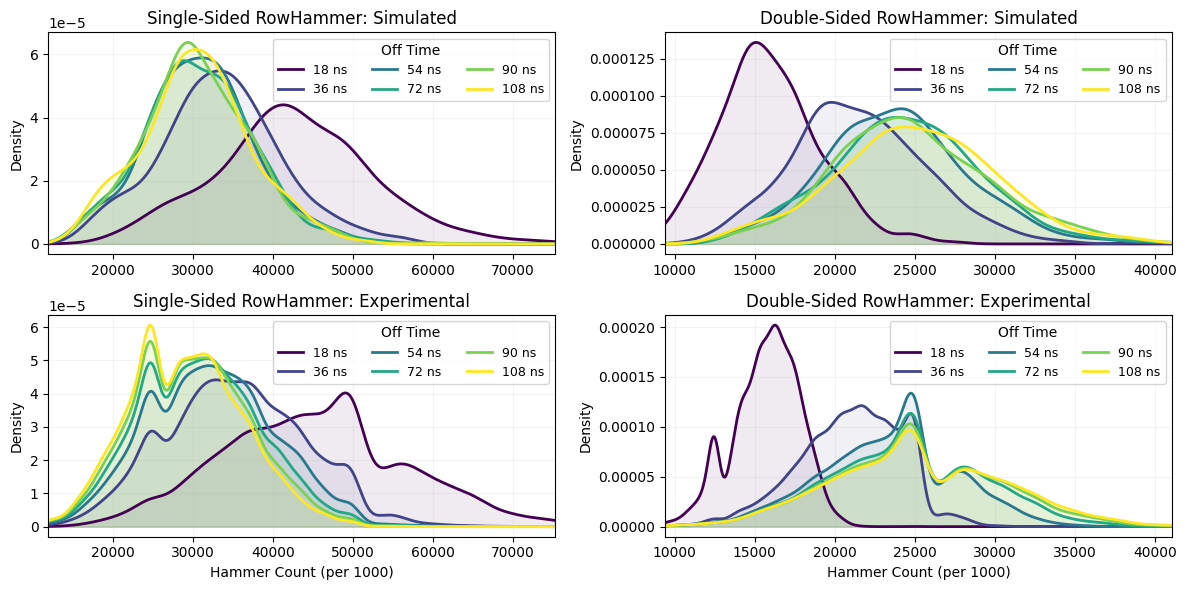

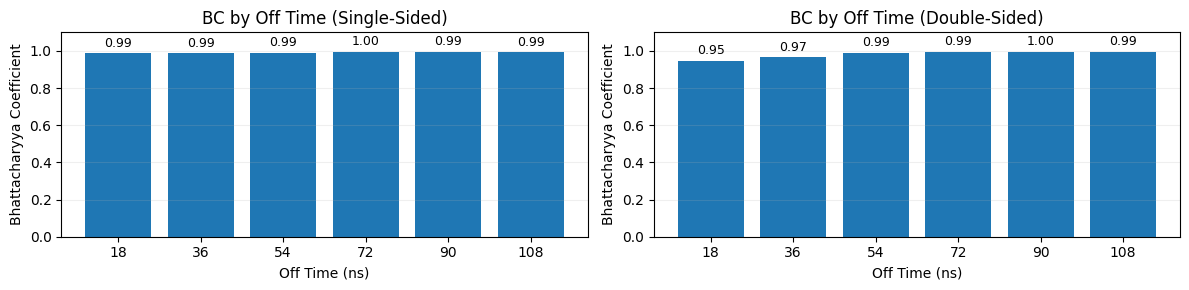

 Test  Off Time  n_exp  n_sim     exp_mean     sim_mean  ks_stat    ks_pvalue  bhatt_coeff  bhatt_dist  nonflip_rate
test1        18  12264   1000 45203.255137 42661.759259 0.148053 3.664156e-18     0.987499    0.012580           0.0
test1        36  12264   1000 35264.336350 33399.111111 0.133378 8.234830e-15     0.987401    0.012679           0.0
test1        54  12264   1000 32358.534817 30867.766667 0.137917 8.258019e-16     0.988574    0.011492           0.0
test1        72  12264   1000 30880.116601 30733.240741 0.093873 1.518868e-07     0.995284    0.004728           0.0
test1        90  12264   1000 29930.505137 30616.626984 0.136827 1.444774e-15     0.994569    0.005446           0.0
test1       108  12264   1000 29233.354697 30400.270833 0.162117 1.041741e-21     0.992022    0.008010           0.0
test4        18  12264   1000 15742.945450 15898.768519 0.131307 2.291251e-14     0.947231    0.054213           0.0
test4        36  12264   1000 21033.163405 21527.166667 0.168080

In [ ]:
# θ_best is your (2d,) vector = [μ_0..μ_{d-1}, logσ_0..logσ_{d-1}] in NATURAL logs

for i in thetas:
    theta_best=i

    out = simulate_and_compare_with_bhattacharyya(
        df=df,
        configs=configs_one,
        regime="one",            # or "zero"
        theta_best=theta_best,
        n_per_bin=1000,
        seed=52,
        bw_adjust=1            # matches the KDE smoothing you used earlier
    )

    # Per-bin table with similarity scores:
    print(
        out["summary"]
        .sort_values(["Test","Off Time"])
        [["Test","Off Time","n_exp","n_sim",
            "exp_mean","sim_mean","ks_stat","ks_pvalue",
            "bhatt_coeff","bhatt_dist","nonflip_rate"]]
        .to_string(index=False)
    )
    break


### 0 --> 1

In [ ]:
# --- model metadata (ZERO regime) ---
PARAMS_ZERO = ['tau_double','trap_single','k_double','k_mult','I_double','I_single','I_const','k_switch']
FAMILY_ZERO = {
    'tau_double':'lognormal', 'trap_single':'lognormal',
    'I_double':'lognormal', 'I_single':'lognormal', 'I_const':'lognormal',
    'k_double':'normal_pos', 'k_mult':'normal_pos', 'k_switch':'normal_pos'
}

configs_zero = [
    ParamConfig("tau_double",  "lognormal",  mean=20e-9,  std=10e-9,
                mu_bounds=(-9, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("trap_single", "lognormal",  mean=50e-9,  std=20e-9,
                mu_bounds=(-9, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("k_double",    "normal_pos", mean=5.0,    std=2.0,
                mu_bounds=(0, 20),  log_sigma_bounds=(-3, 1)),
    ParamConfig("k_mult",      "normal_pos", mean=4.0,    std=1.5,
                mu_bounds=(0, 20),  log_sigma_bounds=(-3, 1)),

    # same halved I_* means
    ParamConfig("I_double",    "lognormal",  mean=80e-9,  std=80e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_single",    "lognormal",  mean=2.5e-9, std=3e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),
    ParamConfig("I_const",     "lognormal",  mean=5e-9,   std=5e-9,
                mu_bounds=(-12, -6), log_sigma_bounds=(-5, 1)),

    ParamConfig("k_switch",    "normal_pos", mean=17.0,   std=5.0,
                mu_bounds=(10, 30), log_sigma_bounds=(-3, 1)),
]


In [ ]:
thetas = []

In [ ]:
# θ_best is your (2d,) vector = [μ_0..μ_{d-1}, logσ_0..logσ_{d-1}] in NATURAL logs

for i in thetas:
    theta_best=i

    out = simulate_and_compare_with_bhattacharyya(
        df=df,
        configs=configs_one,
        regime="zero",            # or "zero"
        theta_best=theta_best,
        n_per_bin=1000,
        seed=2,
        bw_adjust=1            # matches the KDE smoothing you used earlier
    )

    # Per-bin table with similarity scores:
    print(
        out["summary"]
        .sort_values(["Test","Off Time"])
        [["Test","Off Time","n_exp","n_sim",
            "exp_mean","sim_mean","ks_stat","ks_pvalue",
            "bhatt_coeff","bhatt_dist","nonflip_rate"]]
        .to_string(index=False)
    )
    break


# End